In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#define global figure settings
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

custom_params = {"axes.spines.right": False,
                 "axes.spines.top": False,
                 'ytick.left': True,
                 'xtick.bottom': True,
                'grid.linestyle': "" #gets rid of horizontal lines
                }
sns.set_theme(font_scale=1, style="white", rc=custom_params)

# read data

In [3]:
MODELNAME = "bert-base-cased"
METRIC = "OriginalPLL"
DATAPATH = f"results/LibriSpeech/{MODELNAME}/LibriSpeech_{METRIC}.csv"

df = pd.read_csv(DATAPATH)

In [4]:
# add nr. of words
if 'nr. of words' in df.columns:
    df = df.drop(columns=['nr. of words'])
df['nr. of words'] = df['ref sentence'].apply(lambda x: len(x.split()))

In [5]:
df['nr. of words'].describe()

count    2620.000000
mean       20.067176
std        13.725868
min         1.000000
25%        10.000000
50%        16.500000
75%        27.000000
max        96.000000
Name: nr. of words, dtype: float64

In [6]:
test = df.groupby('nr. of tokens').count().reset_index()
test[test["nr. of tokens"] == 18]

,nr. of tokens,sentence id,ref sentence,PLL score,nr. of words
14,18,98,98,98,98


In [7]:
# avg. number of tokens per word
df['avg. nr. of tokens'] = df['nr. of tokens']/df['nr. of words']

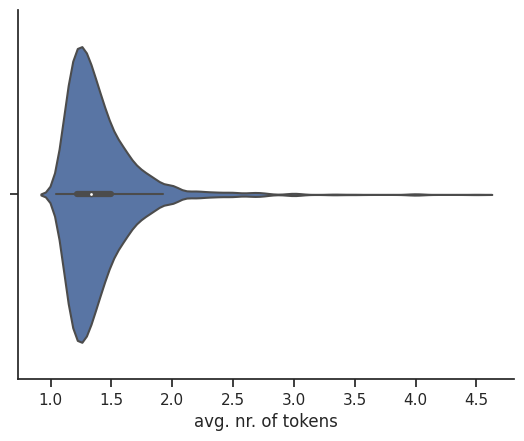

In [8]:
sns.violinplot(x=df["avg. nr. of tokens"])
plt.show()

In [9]:
df['avg. nr. of tokens'].describe()

count    2620.000000
mean        1.406477
std         0.305141
min         1.046875
25%         1.216216
50%         1.333333
75%         1.500000
max         4.500000
Name: avg. nr. of tokens, dtype: float64

In [10]:
# adding quantile rank column to the DataFrame
df['quantile rank'] = pd.qcut(df['avg. nr. of tokens'], 4, labels = False)

In [11]:
pd.qcut(df['avg. nr. of tokens'], 4)

0         (1.333, 1.5]
1           (1.5, 4.5]
2         (1.333, 1.5]
3           (1.5, 4.5]
4         (1.333, 1.5]
             ...      
2615    (1.216, 1.333]
2616      (1.333, 1.5]
2617    (1.216, 1.333]
2618    (1.216, 1.333]
2619    (1.046, 1.216]
Name: avg. nr. of tokens, Length: 2620, dtype: category
Categories (4, interval[float64, right]): [(1.046, 1.216] < (1.216, 1.333] < (1.333, 1.5] < (1.5, 4.5]]

In [12]:
df['negative PLL score'] = -df['PLL score']
df.head()

,sentence id,ref sentence,PLL score,nr. of tokens,nr. of words,avg. nr. of tokens,quantile rank,negative PLL score
0,1089-134686-0000,He hoped there would be stew for dinner turnip...,-97.770535,40,28,1.428571,2,97.770535
1,1089-134686-0001,Stuff it into you his belly counselled him.,-45.689003,13,8,1.625000,3,45.689003
2,1089-134686-0002,After early nightfall the yellow lamps would l...,-38.959395,26,18,1.444444,2,38.959395
3,1089-134686-0003,Hello bertie any good in your mind.,-52.895133,12,7,1.714286,3,52.895133
4,1089-134686-0004,Number ten fresh nelly is waiting on you good ...,-64.655860,15,11,1.363636,2,64.655860


In [13]:
save_df = df[['sentence id', 'ref sentence', 'PLL score', 'negative PLL score', 'nr. of tokens', 'nr. of words', 'avg. nr. of tokens', 'quantile rank']]
save_df.to_csv(f"results/LibriSpeech/{MODELNAME}/analyzed.csv", index=False)             

# plot

In [14]:
#avg. scores over number of tokens (see Salazar et al. (2021))
plot_df = df.groupby('nr. of tokens').mean().reset_index()
plot_df.head()

/tmp/ipykernel_3532/2529729424.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plot_df = df.groupby('nr. of tokens').mean().reset_index()


,nr. of tokens,PLL score,nr. of words,avg. nr. of tokens,quantile rank,negative PLL score
0,4,-11.284954,1.000000,4.000000,3.0,11.284954
1,5,-14.848066,2.000000,2.500000,3.0,14.848066
2,6,-20.780723,2.600000,2.400000,3.0,20.780723
3,7,-21.232230,3.800000,1.886111,3.0,21.232230
4,8,-20.086307,4.510204,1.882993,3.0,20.086307


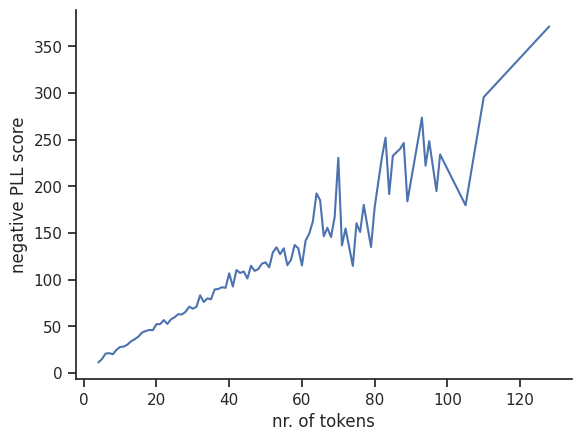

In [15]:
sns.lineplot(data=plot_df, x = "nr. of tokens", y = "negative PLL score")
plt.show()

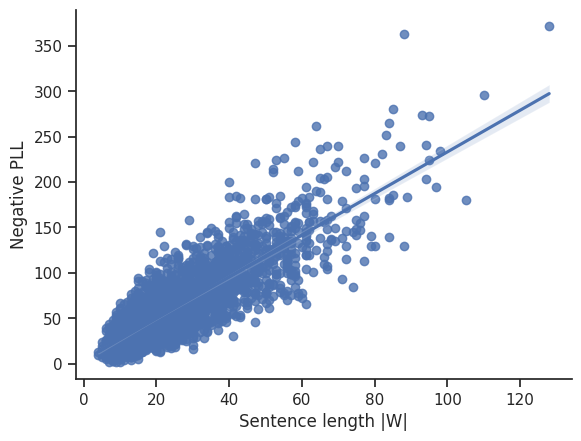

In [16]:
sns.regplot(data=df, x = "nr. of tokens", y = "negative PLL score")
plt.xlabel('Sentence length |W|')
plt.ylabel('Negative PLL')
#plt.savefig(f'NewPLL_scoreVsLength.svg', dpi=180)
#plt.savefig(f'NewPLL_scoreVsLength.png', dpi=180, bbox_inches='tight')
plt.show()

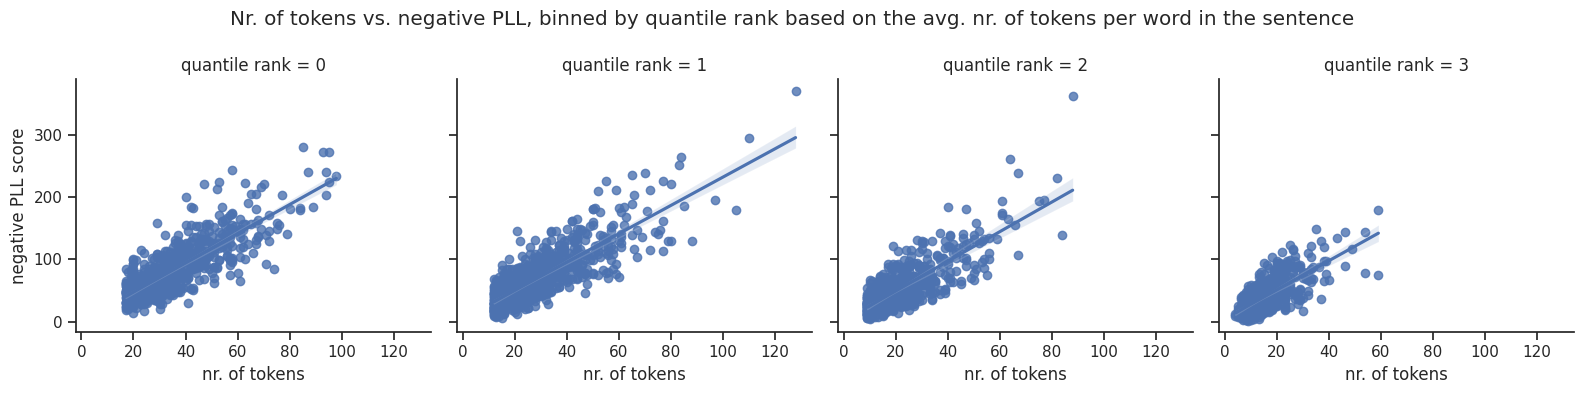

In [17]:
g = sns.FacetGrid(df, col="quantile rank", sharex=True, sharey=True, height=4)
g.map(sns.regplot, "nr. of tokens", "negative PLL score")
g.fig.suptitle('Nr. of tokens vs. negative PLL, binned by quantile rank based on the avg. nr. of tokens per word in the sentence')
plt.tight_layout()
plt.show()

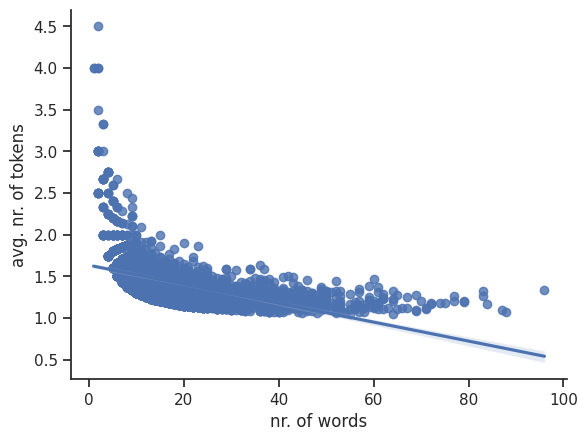

In [19]:
sns.regplot(data=df, x = "nr. of words", y = "avg. nr. of tokens")
plt.show()

In [21]:
test_df = df.loc[df['nr. of words'] >= 20]
# adding quantile rank column to the DataFrame
test_df['quantile rank'] = pd.qcut(test_df['avg. nr. of tokens'], 4, labels = False)

/tmp/ipykernel_3532/3181069202.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['quantile rank'] = pd.qcut(test_df['avg. nr. of tokens'], 4, labels = False)


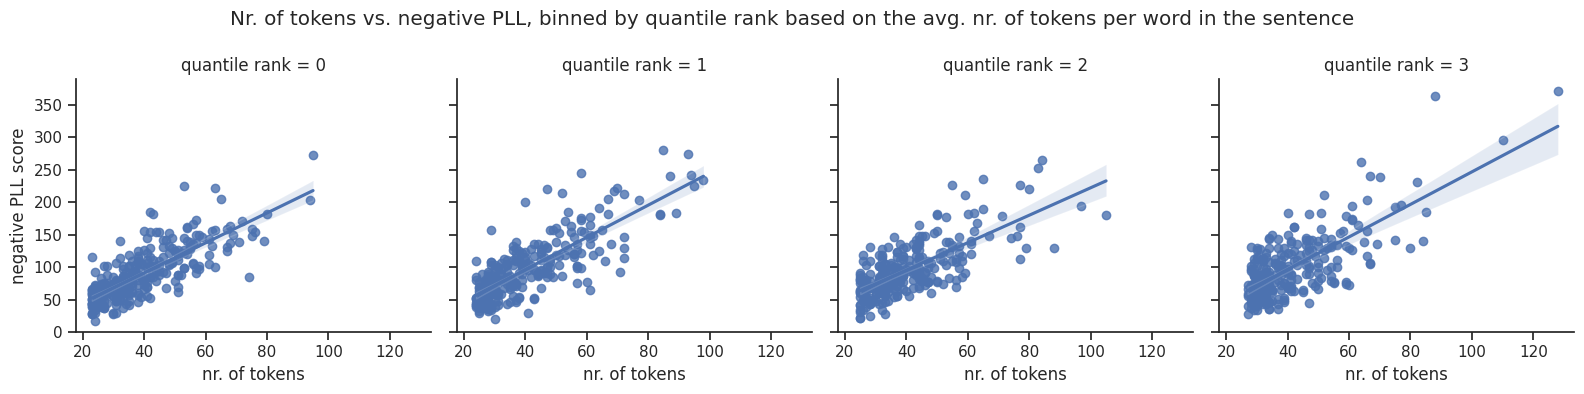

In [22]:
g = sns.FacetGrid(test_df, col="quantile rank", sharex=True, sharey=True, height=4)
g.map(sns.regplot, "nr. of tokens", "negative PLL score")
g.fig.suptitle('Nr. of tokens vs. negative PLL, binned by quantile rank based on the avg. nr. of tokens per word in the sentence')
plt.tight_layout()
plt.show()